***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

### HTML Read Data

In [4]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)



#### Dropping constants

col_no_unique=[]
for col in df_html.columns[:-1]:
    if len(df_html[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_html.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### 95% same values

lst=[]
for col in df_html.columns[:-1]:
    lst.append([col,dict(df_html[col].value_counts()),df_html[col].value_counts().values[0]>=len(df_html)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_html.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_html.shape)

#### Dropping columns based on high VIF values

rem=['a_href_absolute','a_href_relative','a_count','a_href_out_of_domain',
     'base_count','base_href_absolute','base_href_out_of_domain',
     'iframe_src_absolute','iframe_src_relative','iframe_sandbox_allow_same_origin_count','iframe_src_http',
     'img_src_absolute','img_src_http','img_srcset_absolute','img_src_relative','img_srcset_relative','img_count',
     'script_src_absolute','script_src_http','script_src_relative','script_count','script_src_https',
     'link_rel_wlwmanifest','link_href_absolute','link_href_relative','link_rel_EditURI','link_count',
     'link_type_application/wlwmanifest+xml','link_href_https','link_rel_stylesheet','link_href_.png',
     'form_action_absolute','form_action_relative','form_count','form_action_https',
     'form_enctype_application/x-www-form-urlencoded',
     'tbody_count',
     'nofollow_count']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_html.shape)

Shape of HTML dataset: (43491, 1461)
0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1464)
1297 columns have more than 95% same values
Shape of our dataset after dropping them: (43491, 167)
38 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43491, 129)


### JavaScript read data

In [5]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Dropping constants

col_no_unique=[]
for col in df_js.columns[:-1]:
    if len(df_js[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df_js.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)

#### 95% same values

lst=[]
for col in df_js.columns[:-1]:
    lst.append([col,dict(df_js[col].value_counts()),df_js[col].value_counts().values[0]>=len(df_js)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst


print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

df_js.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df_js.shape)


#### Dropping columns based on high VIF values

rem=['js_function_.defineProperty(','js_function_.keys(','js_function_.substr','js_function_unescape(','js_function_.log(']

print('{} columns are dropped because of high VIF values'.format(len(rem)))
df_js.drop(rem,axis=1,inplace=True)
print("Shape of our dataset after dropping them:",df_js.shape)

113 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43294, 288)
234 columns have more than 95% same values
Shape of our dataset after dropping them: (43294, 54)
5 columns are dropped because of high VIF values
Shape of our dataset after dropping them: (43294, 49)


In [6]:
df=pd.concat([df_js,df_html],axis=1,join='inner')
df['Target_z']=df[['Target','Target']].apply(max,axis=1)
df.drop(['Target','Target'],axis=1,inplace=True)
df.rename(columns={'Target_z':'Target'},inplace=True)

In [7]:
df_sel=df.copy(deep=True)

In [8]:
X=df_sel.iloc[:,df_sel.columns!='Target']
Y=df_sel.Target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(model.feature_importances_)

# for thresh in thresholds:
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     selection_model = XGBClassifier(random_state=0)
#     selection_model.fit(select_X_train, y_train)
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 90.63%


In [9]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.010, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=0)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

selection_model = selection.get_support()
embeded_rf_feature = X.loc[:,selection_model].columns.tolist()

embeded_rf_feature.append('Target')
embeded_rf_feature

['dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.setTimeout(',
 'js_function_.find(',
 'js_function_.get(',
 'js_function_.indexOf(',
 'js_function_.push(',
 'js_function_.replace(',
 'a_href_.com',
 'a_href_https',
 'center_count',
 'form_action_http',
 'iframe_src_https',
 'link_href_.css',
 'link_href_http',
 'link_href_out_of_domain',
 'link_rel_shortlink',
 'link_type_application/rsd+xml',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'script_src_out_of_domain',
 'strong_count',
 'total_count',
 'total_href',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [10]:
fin_col=embeded_rf_feature
df_sel=df_sel[fin_col]

In [11]:
train=df_sel.iloc[:28496,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

In [12]:
scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

In [13]:
test=df_sel.iloc[28496:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [14]:
train.shape

(28496, 27)

In [15]:
columns=fin_col
columns.remove('Target')

In [16]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8718416619876473
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24183   157    24340
True        3495   661     4156
__all__    27678   818    28496

Accuracy of the model for test data is: 0.8674363383280111
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10361    77    10438
True        1542   233     1775
__all__    11903   310    12213



Logistic Regression
Accuracy of the model for training data is: 0.8890370578326783
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      21977  2363    24340
True         799  3357     4156
__all__    22776  5720    28496

Accuracy of the model for test data is: 0.8900352083845083
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9418  1020    10438
True         323  1452     1775
__all__     9741  2472    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9265160022459292
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22414  1926    24340
True         168  3988     4156
__all__    22582  5914    28496

Accuracy of the model for test data is: 0.9111602390894948
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9555   883    10438
True         202  1573     1775
__all__     9757  2456    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.9041268950028074
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22354  1986    24340
True         746  3410     4156
__all__    23100  5396    28496

Accuracy of the model for test data is: 0.9031360026201588
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9552   886    10438
True         297  1478     1775
__all__     9849  2364    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9102681078046042
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22406  1934    24340
True         623  3533     4156
__all__    23029  5467    28496

Accuracy of the model for test data is: 0.9074756407107181
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9567   871    10438
True         259  1516     1775
__all__     9826  2387    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9284460976979225
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22415  1925    24340
True         114  4042     4156
__all__    22529  5967    28496

Accuracy of the model for test data is: 0.9118971587652501
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9556   882    10438
True         194  1581     1775
__all__     9750  2463    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9261299831555306
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22413  1927    24340
True         178  3978     4156
__all__    22591  5905    28496

Accuracy of the model for test data is: 0.9112421190534676
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9545   893    10438
True         191  1584     1775
__all__     9736  2477    12213



Neural Network-1
The accuracy of the model on training data is: 0.9073203256597417


Predicted  False  True  __all__
Actual                         
False      22005  2335    24340
True         306  3850     4156
__all__    22311  6185    28496

The accuracy of the model on test data is: 0.8997789240972734


Predicted  False  True  __all__
Actual                         
False       9406  1032    10438
True         192  1583     1775
__all__     9598  2615    12213

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [17]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [18]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871842,661.0,24183.0,157.0,3495.0,0.006450,0.840953
LogisticRegression,0.889037,3357.0,21977.0,2363.0,799.0,0.097083,0.192252
RandomForestClassifier,0.926516,3988.0,22414.0,1926.0,168.0,0.079129,0.040423
AdaBoostClassifier,0.904127,3410.0,22354.0,1986.0,746.0,0.081594,0.179500
GradientBoostingClassifier,0.910268,3533.0,22406.0,1934.0,623.0,0.079458,0.149904
ExtraTreeClassifier,0.928446,4042.0,22415.0,1925.0,114.0,0.079088,0.027430
BaggingClassifier,0.926130,3978.0,22413.0,1927.0,178.0,0.079170,0.042830
Neural Network-1,0.907320,3850.0,22005.0,2335.0,306.0,0.095933,0.073628


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.867436,233.0,10361.0,77.0,1542.0,0.007377,0.868732,0.561945,0.277612
LogisticRegression,0.890035,1452.0,9418.0,1020.0,323.0,0.097720,0.181972,0.860154,0.631830
RandomForestClassifier,0.911160,1573.0,9555.0,883.0,202.0,0.084595,0.113803,0.900801,0.704846
AdaBoostClassifier,0.903136,1478.0,9552.0,886.0,297.0,0.084882,0.167324,0.873897,0.667068
GradientBoostingClassifier,0.907476,1516.0,9567.0,871.0,259.0,0.083445,0.145915,0.885320,0.684927
ExtraTreeClassifier,0.911897,1581.0,9556.0,882.0,194.0,0.084499,0.109296,0.903103,0.708140
BaggingClassifier,0.911242,1584.0,9545.0,893.0,191.0,0.085553,0.107606,0.903421,0.707201
Neural Network-1,0.899779,1583.0,9406.0,1032.0,192.0,0.098870,0.108169,0.896481,0.681293


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [19]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [20]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [21]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9348397699260477
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      21828   2512    24340
True         660  23680    24340
__all__    22488  26192    48680

Accuracy of the model for test data is: 0.8838123311225743
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9167  1271    10438
True         148  1627     1775
__all__     9315  2898    12213



Logistic Regression
Accuracy of the model for training data is: 0.8896055875102712
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      19943   4397    24340
True         977  23363    24340
__all__    20920  27760    48680

Accuracy of the model for test data is: 0.8421354294604111
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8599  1839    10438
True          89  1686     1775
__all__     8688  3525    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9530402629416598
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22293   2047    24340
True         239  24101    24340
__all__    22532  26148    48680

Accuracy of the model for test data is: 0.9085400802423647
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9483   955    10438
True         162  1613     1775
__all__     9645  2568    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.9065735414954806
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      20965   3375    24340
True        1173  23167    24340
__all__    22138  26542    48680

Accuracy of the model for test data is: 0.8722672562024073
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8999  1439    10438
True         121  1654     1775
__all__     9120  3093    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9258833196384553
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      21574   2766    24340
True         842  23498    24340
__all__    22416  26264    48680

Accuracy of the model for test data is: 0.8912634078441005
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9252  1186    10438
True         142  1633     1775
__all__     9394  2819    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.953759244042728
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22300   2040    24340
True         211  24129    24340
__all__    22511  26169    48680

Accuracy of the model for test data is: 0.9091951199541473
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9496   942    10438
True         167  1608     1775
__all__     9663  2550    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9527321281840592
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22293   2047    24340
True         254  24086    24340
__all__    22547  26133    48680

Accuracy of the model for test data is: 0.9059199213952346
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9447   991    10438
True         158  1617     1775
__all__     9605  2608    12213



Neural Network-1
The accuracy of the model on training data is: 0.9372843056696796


Predicted  False   True  __all__
Actual                          
False      21555   2785    24340
True         268  24072    24340
__all__    21823  26857    48680

The accuracy of the model on test data is: 0.8852042905101122


Predicted  False  True  __all__
Actual                         
False       9157  1281    10438
True         121  1654     1775
__all__     9278  2935    12213

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [22]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [23]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.934840,23680.0,21828.0,2512.0,660.0,0.103205,0.027116
LogisticRegression,0.889606,23363.0,19943.0,4397.0,977.0,0.180649,0.040140
RandomForestClassifier,0.953040,24101.0,22293.0,2047.0,239.0,0.084100,0.009819
AdaBoostClassifier,0.906574,23167.0,20965.0,3375.0,1173.0,0.138661,0.048192
GradientBoostingClassifier,0.925883,23498.0,21574.0,2766.0,842.0,0.113640,0.034593
ExtraTreeClassifier,0.953759,24129.0,22300.0,2040.0,211.0,0.083813,0.008669
BaggingClassifier,0.952732,24086.0,22293.0,2047.0,254.0,0.084100,0.010435
Neural Network-1,0.937284,24072.0,21555.0,2785.0,268.0,0.114421,0.011011


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.883812,1627.0,9167.0,1271.0,148.0,0.121767,0.083380,0.897427,0.658497
LogisticRegression,0.842135,1686.0,8599.0,1839.0,89.0,0.176183,0.050141,0.886838,0.601766
RandomForestClassifier,0.908540,1613.0,9483.0,955.0,162.0,0.091493,0.091268,0.908620,0.706820
AdaBoostClassifier,0.872267,1654.0,8999.0,1439.0,121.0,0.137862,0.068169,0.896985,0.643464
GradientBoostingClassifier,0.891263,1633.0,9252.0,1186.0,142.0,0.113623,0.080000,0.903188,0.674486
ExtraTreeClassifier,0.909195,1608.0,9496.0,942.0,167.0,0.090247,0.094085,0.907834,0.707286
BaggingClassifier,0.905920,1617.0,9447.0,991.0,158.0,0.094942,0.089014,0.908022,0.701809
Neural Network-1,0.885204,1654.0,9157.0,1281.0,121.0,0.122725,0.068169,0.904553,0.667394


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [24]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [25]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

1    4156
0    4156
Name: Target, dtype: int64

In [26]:
X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

In [27]:
print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (8312, 26)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5821703561116458
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4025   131     4156
True        3342   814     4156
__all__     7367   945     8312

Accuracy of the model for test data is: 0.8401703103250635
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9962   476    10438
True        1476   299     1775
__all__    11438   775    12213



Logistic Regression
Accuracy of the model for training data is: 0.8807747834456208
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3325   831     4156
True         160  3996     4156
__all__     3485  4827     8312

Accuracy of the model for test data is: 0.8273151559813313
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8404  2034    10438
True          75  1700     1775
__all__     8479  3734    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9488691049085659
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3817   339     4156
True          86  4070     4156
__all__     3903  4409     8312

Accuracy of the model for test data is: 0.8974862851060346
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9316  1122    10438
True         130  1645     1775
__all__     9446  2767    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.8965351299326275
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3518   638     4156
True         222  3934     4156
__all__     3740  4572     8312

Accuracy of the model for test data is: 0.8612953410300499
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8836  1602    10438
True          92  1683     1775
__all__     8928  3285    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9128970163618865
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3668   488     4156
True         236  3920     4156
__all__     3904  4408     8312

Accuracy of the model for test data is: 0.8825841316629821
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9129  1309    10438
True         125  1650     1775
__all__     9254  2959    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9534408084696824
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3817   339     4156
True          48  4108     4156
__all__     3865  4447     8312

Accuracy of the model for test data is: 0.9015802833046753
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9375  1063    10438
True         139  1636     1775
__all__     9514  2699    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9501924927815207
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3813   343     4156
True          71  4085     4156
__all__     3884  4428     8312

Accuracy of the model for test data is: 0.8927372471956112
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9251  1187    10438
True         123  1652     1775
__all__     9374  2839    12213



Neural Network-1
The accuracy of the model on training data is: 0.9216794994614007


Predicted  False  True  __all__
Actual                         
False       3602   554     4156
True          97  4059     4156
__all__     3699  4613     8312

The accuracy of the model on test data is: 0.8599033816425121


Predicted  False  True  __all__
Actual                         
False       8824  1614    10438
True          97  1678     1775
__all__     8921  3292    12213

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [28]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [29]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.582170,814.0,4025.0,131.0,3342.0,0.031521,0.804139
LogisticRegression,0.880775,3996.0,3325.0,831.0,160.0,0.199952,0.038499
RandomForestClassifier,0.948869,4070.0,3817.0,339.0,86.0,0.081569,0.020693
AdaBoostClassifier,0.896535,3934.0,3518.0,638.0,222.0,0.153513,0.053417
GradientBoostingClassifier,0.912897,3920.0,3668.0,488.0,236.0,0.117421,0.056785
ExtraTreeClassifier,0.953441,4108.0,3817.0,339.0,48.0,0.081569,0.011550
BaggingClassifier,0.950192,4085.0,3813.0,343.0,71.0,0.082531,0.017084
Neural Network-1,0.921679,4059.0,3602.0,554.0,97.0,0.133301,0.023340


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.840170,299.0,9962.0,476.0,1476.0,0.045603,0.831549,0.561424,0.177603
LogisticRegression,0.827315,1700.0,8404.0,2034.0,75.0,0.194865,0.042254,0.881441,0.583587
RandomForestClassifier,0.897486,1645.0,9316.0,1122.0,130.0,0.107492,0.073239,0.909634,0.689772
AdaBoostClassifier,0.861295,1683.0,8836.0,1602.0,92.0,0.153478,0.051831,0.897346,0.631628
GradientBoostingClassifier,0.882584,1650.0,9129.0,1309.0,125.0,0.125407,0.070423,0.902085,0.661483
ExtraTreeClassifier,0.901580,1636.0,9375.0,1063.0,139.0,0.101839,0.078310,0.909925,0.696401
BaggingClassifier,0.892737,1652.0,9251.0,1187.0,123.0,0.113719,0.069296,0.908493,0.681674
Neural Network-1,0.859903,1678.0,8824.0,1614.0,97.0,0.154627,0.054648,0.895362,0.628053


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [30]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [31]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 1326 features
EntitySet scattered to workers in 4.286 seconds
Elapsed: 00:06 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [32]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [35]:
# X=fs.loc[:,fs.columns!='Target']
# y=fs.Target
# feature_name = X.columns.tolist()

In [33]:
feature_name=['total_count',
 'strong_count + total_count',
 'script_src_out_of_domain + total_count',
 'script_async_true + total_count',
 'script_async_true + script_src_out_of_domain',
 'p_count + total_count',
 'meta_count + total_count',
 'link_type_text/css + total_count',
 'link_type_application/rsd+xml + total_count',
 'link_rel_shortlink + total_count',
 'link_href_out_of_domain + total_count',
 'link_href_http + total_count',
 'link_href_.css + total_count',
 'js_function_.replace( + total_count',
 'js_function_.push( + total_count',
 'js_function_.indexOf( + total_count',
 'js_function_.get( + total_count',
 'js_function_.find( + total_count',
 'iframe_src_https + total_count',
 'form_action_http + total_count',
 'dom_function_window.addEventListener( + total_count',
 'dom_function_document.write( + total_count',
 'center_count + total_count',
 'a_href_.com + total_count',
 'total_href / total_count',
 'total_count / link_href_out_of_domain',
 'total_count + total_href',
 'script_src_out_of_domain',
 'link_type_application/rsd+xml + script_src_out_of_domain',
 'link_rel_shortlink + script_src_out_of_domain',
 'link_href_.css + script_src_out_of_domain',
 'js_function_.indexOf( + script_async_true',
 'js_function_.get( + script_async_true',
 'iframe_src_https + script_src_out_of_domain',
 'form_action_http + script_src_out_of_domain',
 'dom_function_window.setTimeout( + total_count',
 'dom_function_window.setTimeout( + script_src_out_of_domain',
 'dom_function_window.addEventListener( + script_src_out_of_domain',
 'a_href_https / total_href',
 'a_href_https + total_count']

In [34]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:28496]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[28496:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [35]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8719118472768108
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24209   131    24340
True        3519   637     4156
__all__    27728   768    28496

Accuracy of the model for test data is: 0.8676819782199295
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10377    61    10438
True        1555   220     1775
__all__    11932   281    12213



Logistic Regression
Accuracy of the model for training data is: 0.8760527793374508
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      21606  2734    24340
True         798  3358     4156
__all__    22404  6092    28496

Accuracy of the model for test data is: 0.8766068942929666
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9248  1190    10438
True         317  1458     1775
__all__     9565  2648    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9259194272880404
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22413  1927    24340
True         184  3972     4156
__all__    22597  5899    28496

Accuracy of the model for test data is: 0.9107508392696307
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9553   885    10438
True         205  1570     1775
__all__     9758  2455    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.8988279056709714
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22363  1977    24340
True         906  3250     4156
__all__    23269  5227    28496

Accuracy of the model for test data is: 0.8969131253582249
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9553   885    10438
True         374  1401     1775
__all__     9927  2286    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9113559797866367
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22422  1918    24340
True         608  3548     4156
__all__    23030  5466    28496

Accuracy of the model for test data is: 0.9073118807827725
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9576   862    10438
True         270  1505     1775
__all__     9846  2367    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9284460976979225
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22415  1925    24340
True         114  4042     4156
__all__    22529  5967    28496

Accuracy of the model for test data is: 0.9104233194137394
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9550   888    10438
True         206  1569     1775
__all__     9756  2457    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9257439640651319
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22413  1927    24340
True         189  3967     4156
__all__    22602  5894    28496

Accuracy of the model for test data is: 0.909768279701957
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9546   892    10438
True         210  1565     1775
__all__     9756  2457    12213



Neural Network-1


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

The accuracy of the model on training data is: 0.881106120157215


Predicted  False  True  __all__
Actual                         
False      21448  2892    24340
True         496  3660     4156
__all__    21944  6552    28496

The accuracy of the model on test data is: 0.8788176533202325


Predicted  False  True  __all__
Actual                         
False       9174  1264    10438
True         216  1559     1775
__all__     9390  2823    12213

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [36]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [37]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871912,637.0,24209.0,131.0,3519.0,0.005382,0.846728
LogisticRegression,0.876053,3358.0,21606.0,2734.0,798.0,0.112325,0.192012
RandomForestClassifier,0.925919,3972.0,22413.0,1927.0,184.0,0.079170,0.044273
AdaBoostClassifier,0.898828,3250.0,22363.0,1977.0,906.0,0.081224,0.217998
GradientBoostingClassifier,0.911356,3548.0,22422.0,1918.0,608.0,0.078800,0.146295
ExtraTreeClassifier,0.928446,4042.0,22415.0,1925.0,114.0,0.079088,0.027430
BaggingClassifier,0.925744,3967.0,22413.0,1927.0,189.0,0.079170,0.045476
Neural Network-1,0.881106,3660.0,21448.0,2892.0,496.0,0.118817,0.119346


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.867682,220.0,10377.0,61.0,1555.0,0.005844,0.876056,0.559050,0.277617
LogisticRegression,0.876607,1458.0,9248.0,1190.0,317.0,0.114007,0.178592,0.853701,0.605024
RandomForestClassifier,0.910751,1570.0,9553.0,885.0,205.0,0.084786,0.115493,0.899860,0.703299
AdaBoostClassifier,0.896913,1401.0,9553.0,885.0,374.0,0.084786,0.210704,0.852255,0.636572
GradientBoostingClassifier,0.907312,1505.0,9576.0,862.0,270.0,0.082583,0.152113,0.882652,0.682359
ExtraTreeClassifier,0.910423,1569.0,9550.0,888.0,206.0,0.085074,0.116056,0.899435,0.702337
BaggingClassifier,0.909768,1565.0,9546.0,892.0,210.0,0.085457,0.118310,0.898117,0.700019
Neural Network-1,0.878818,1559.0,9174.0,1264.0,216.0,0.121096,0.121690,0.878607,0.633050


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [38]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 30.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

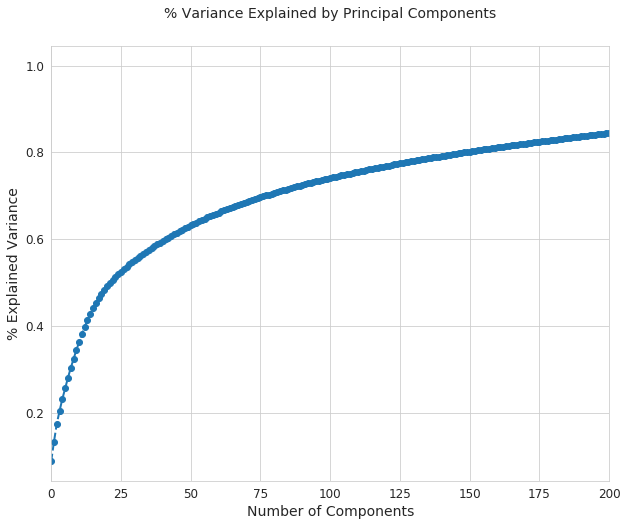

In [39]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [40]:
pca=PCA(n_components=150,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 150 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 150 components is: 0.799309920000696


In [41]:
X_train=X_pca_21[:28496]
Y_train=fs.iloc[:28496]['Target'].values
X_test=X_pca_21[28496:]
Y_test=fs.iloc[28496:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [42]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,150).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9151810780460415
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22351  1989    24340
True         428  3728     4156
__all__    22779  5717    28496

Accuracy of the model for test data is: 0.9069843609268812
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9521   917    10438
True         219  1556     1775
__all__     9740  2473    12213



Logistic Regression
Accuracy of the model for training data is: 0.9033548568220101
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22217  2123    24340
True         631  3525     4156
__all__    22848  5648    28496

Accuracy of the model for test data is: 0.8988782444935725
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9472   966    10438
True         269  1506     1775
__all__     9741  2472    12213



RandomForest Classifier
Accuracy of the model for training data is: 0.9256737787759686
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22415  1925    24340
True         193  3963     4156
__all__    22608  5888    28496

Accuracy of the model for test data is: 0.9111602390894948
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9565   873    10438
True         212  1563     1775
__all__     9777  2436    12213



Adaoost Classifier
Accuracy of the model for training data is: 0.9048989331836047
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22214  2126    24340
True         584  3572     4156
__all__    22798  5698    28496

Accuracy of the model for test data is: 0.9022353230164579
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9493   945    10438
True         249  1526     1775
__all__     9742  2471    12213



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9144792251544076
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22421  1919    24340
True         518  3638     4156
__all__    22939  5557    28496

Accuracy of the model for test data is: 0.9081306804225007
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9569   869    10438
True         253  1522     1775
__all__     9822  2391    12213



ExtraTree Classifier
Accuracy of the model for training data is: 0.9284460976979225
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22415  1925    24340
True         114  4042     4156
__all__    22529  5967    28496

Accuracy of the model for test data is: 0.9119790387292229
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9567   871    10438
True         204  1571     1775
__all__     9771  2442    12213



Bagging Classifier
Accuracy of the model for training data is: 0.9260247052217855
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      22411  1929    24340
True         179  3977     4156
__all__    22590  5906    28496

Accuracy of the model for test data is: 0.9102595594857938
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9548   890    10438
True         206  1569     1775
__all__     9754  2459    12213



Neural Network-1
The accuracy of the model on training data is: 0.9225505334081976


Predicted  False  True  __all__
Actual                         
False      22274  2066    24340
True         141  4015     4156
__all__    22415  6081    28496

The accuracy of the model on test data is: 0.9029722426922132


Predicted  False  True  __all__
Actual                         
False       9426  1012    10438
True         173  1602     1775
__all__     9599  2614    12213

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [43]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [44]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.915181,3728.0,22351.0,1989.0,428.0,0.081717,0.102984
LogisticRegression,0.903355,3525.0,22217.0,2123.0,631.0,0.087223,0.151829
RandomForestClassifier,0.925674,3963.0,22415.0,1925.0,193.0,0.079088,0.046439
AdaBoostClassifier,0.904899,3572.0,22214.0,2126.0,584.0,0.087346,0.140520
GradientBoostingClassifier,0.914479,3638.0,22421.0,1919.0,518.0,0.078841,0.124639
ExtraTreeClassifier,0.928446,4042.0,22415.0,1925.0,114.0,0.079088,0.027430
BaggingClassifier,0.926025,3977.0,22411.0,1929.0,179.0,0.079252,0.043070
Neural Network-1,0.922551,4015.0,22274.0,2066.0,141.0,0.084881,0.033927


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.906984,1556.0,9521.0,917.0,219.0,0.087852,0.123380,0.894384,0.691776
LogisticRegression,0.898878,1506.0,9472.0,966.0,269.0,0.092546,0.151549,0.877952,0.663054
RandomForestClassifier,0.911160,1563.0,9565.0,873.0,212.0,0.083637,0.119437,0.898463,0.702886
AdaBoostClassifier,0.902235,1526.0,9493.0,945.0,249.0,0.090535,0.140282,0.884592,0.674804
GradientBoostingClassifier,0.908131,1522.0,9569.0,869.0,253.0,0.083253,0.142535,0.887106,0.687666
ExtraTreeClassifier,0.911979,1571.0,9567.0,871.0,204.0,0.083445,0.114930,0.900813,0.706378
BaggingClassifier,0.910260,1569.0,9548.0,890.0,206.0,0.085265,0.116056,0.899339,0.701955
Neural Network-1,0.902972,1602.0,9426.0,1012.0,173.0,0.096953,0.097465,0.902791,0.692232


In [45]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')